<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/H93_M76_B93_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# loading modules
from scipy.optimize import brute, fmin
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import minimize
from scipy.integrate import quad
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep
from numpy.ma import minimum_fill_value


In [ ]:
# General Parameters
S0 = 232.90 # initial index level
K = 232.90 # strike level (ATM)
r = 0.015 # constant short rate
no_of_trade_days = 250 # days of trade in a year
maturity = 15
T = maturity/no_of_trade_days # call option maturity


# Heston'93 Parameters
kappa_v = 1.5
theta_v = 0.02
sigma_v = 0.15
rho = 0.1
v0 = 0.01

## Part 1



In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value.
    """
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * ((kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3)))
    H2 = (kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v**2 * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    int_func_value = 1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Valuation of European call option in H93 model via Lewis (2001)
    """
    int_value = quad(lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0), 0, np.inf, limit=250)[0]
    #call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    if model_value is None:
        raise ValueError("Option pricing calculation failed.")

    return call_value

def H93_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Valuation of European put option in H93 model via put-call parity.
    """
    call_value = H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    put_value = call_value + K * np.exp(-r * T) - S0
    return put_value

# Replace dummy_path with the actual path to your Excel file
dummy_path = "MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx"

# Load option data from Excel file (load the first sheet by default)
data = pd.read_excel(dummy_path)

# Select options with 15 days to maturity
options = data[data["Days to maturity"] == maturity]

# Option Selection
S0 = 232.90  # Current price of SM stock

# Tolerance level to select ATM options (percent around ITM/OTM options)
tol = 0.02
options = options[(np.abs(options["Strike"] - S0) / S0) < tol]
options["T"] = options["Days to maturity"] / 250.0  # Assuming 1 year has 250 trading days
options["r"] = 0.015  # Annual risk-free rate of 1.50%

# Error function for parameter calibration
def H93_error_function(p0):
    """Error function for parameter calibration via Lewis (2001) Fourier approach for Heston (1993)."""
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        if option["Type"] == "C":
            model_value = H93_call_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
            )
        else:
            model_value = H93_put_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
    )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

# Calibrates Heston (1993) stochastic volatility model to market quotes
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 12.51, 5.0),  # kappa_v
            (0.01, 0.051, 0.02),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.02),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=1200
    )
    return opt
# Run the calibration
i = 0
min_MSE = 500

result = H93_calibration_full()
kappa_v,theta_v,sigma_v,rho,v0 = result


   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  20.853 |  20.853
  25 | [ 2.5   0.03  0.15 -0.75  0.03] |   9.234 |   9.165
  50 | [ 2.5   0.05  0.15 -0.5   0.01] |  18.510 |   8.645
  75 | [ 7.5   0.01  0.15 -0.5   0.03] |  10.791 |   8.645
 100 | [ 7.5   0.03  0.15 -0.25  0.01] |  17.682 |   8.645
 125 | [ 7.5   0.05  0.15 -0.25  0.03] |   7.836 |   7.806
 150 | [1.25e+01 1.00e-02 1.50e-01 0.00e+00 1.00e-02] |  20.868 |   7.806
 175 | [12.5   0.03  0.15  0.    0.03] |   9.185 |   7.806
 200 | [ 1.25e+01  5.00e-02  2.50e-01 -7.50e-01  1.00e-02] |  12.868 |   7.167
 225 | [ 1.44728960e+01  5.84675840e-02  4.16374400e-02 -2.24601600e-04
  3.63645504e-02] |   5.112 |   5.112
 250 | [ 2.60249959e+01  7.68979476e-02  5.00826230e-03 -2.49410115e-03
  7.68480541e-02] |   0.822 |   0.622
 275 | [ 2.91845362e+01  9.02468001e-02  2.12878818e-03 -3.63539962e-03
  9.56882423e-02] |   0.403 |   0.403
 300 | [ 2.91930626e+01  9.03282161e-02  2.62758326e-03 -3.62722713e-03
  9.72604605e-02] |   0.402 |   

In [ ]:
kappa_v,theta_v,sigma_v,rho,v0 = result
model_values = [H93_call_value(S0, option["Strike"], option["T"], option["r"], kappa_v,theta_v,sigma_v,rho,v0) for _, option in options.iterrows()]

strike_prices = np.linspace(options['Strike'].min()*0.99, options['Strike'].max()*1.01, 100)
get_H93_call_price = np.vectorize(lambda x: H93_call_value(S0, x, maturity/no_of_trade_days, r, kappa_v,theta_v,sigma_v,rho,v0))
get_H93_put_price = np.vectorize(lambda x: H93_put_value(S0, x, maturity/no_of_trade_days, r, kappa_v,theta_v,sigma_v,rho,v0))
call_prices = get_H93_call_price(strike_prices)
put_prices = get_H93_put_price(strike_prices)

fig = go.Figure(
    data = [
        go.Scatter(x=options.loc[options.Type == 'C', 'Strike'], y=options.loc[options.Type == 'C', 'Price'], marker=dict(color='red'), mode='markers', name='Market Call Price'),
        go.Scatter(x=options.loc[options.Type == 'P', 'Strike'], y=options.loc[options.Type == 'P', 'Price'], marker=dict(color='green'), mode='markers', name='Market Call Price from Put Price'),
        go.Scatter(x=strike_prices, y=call_prices, name='H93 call prices', line=dict(color='blue', dash='dash'), mode='lines'),
        go.Scatter(x=strike_prices, y=put_prices, name='H93 put prices', line=dict(color='yellow', dash='dash'), mode='lines')
    ]
)

kappa_v,theta_v,sigma_v,rho,v0 = result

fig.update_layout(title=f'\nPrices of the Call and Put Option S0={S0}, T={maturity}d for the various strikes')
fig.show()


In [ ]:
print("\nWe observe pretty decent fit for Heston (1993) model trying to satisfy Call options available on the market")
print(f"\nCalibration parameters for Heston model: \n========================\nkappa = {np.round(kappa_v,4)}, \ntheta= {np.round(theta_v,4)}, \nsigma= {np.round(sigma_v,4)}, \nrho= {np.round(rho,4)}, \nv0= {np.round(v0,4)}")



We observe pretty decent fit for Heston (1993) model trying to satisfy Call options available on the market

Calibration parameters for Heston model: 
kappa = 29.2038, 
theta= 0.0905, 
sigma= 0.0026, 
rho= -0.0036, 
v0= 0.0973


As the client is looking for a very short maturity for her derivative, we first get the data of option price with 15 days maturity to calibrate the model.
We then build up the valuation functino for the heston model. After that, we use an error function to calculate the difference between model prices and observed market prices. Finally, we optimize the error function by finding the value for the parameters that result in the smallest difference between the model price and the market price.

In [ ]:
def heston_paths_mc(S0, v0, r, kappa_v, theta_v, sigma_v, rho, T, M, Ite):
    dt = T / M
    sdt = np.sqrt(dt)

    # Generate random numbers
    rand = np.random.standard_normal((2, M + 1, Ite))

    # Covariance matrix
    covariance_matrix = np.array([[1.0, rho], [rho, 1.0]])
    cho_matrix = np.linalg.cholesky(covariance_matrix)

    # Initialize arrays for stock price and volatility
    S = np.zeros((M + 1, Ite), dtype=float)
    V = np.zeros((M + 1, Ite), dtype=float)

    # Set initial values
    S[0] = S0
    V[0] = v0

    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])

        # Update volatility using stochastic volatility model
        V[t] = np.maximum(0, V[t - 1] + kappa_v * (theta_v - V[t - 1]) * dt
                          + np.sqrt(V[t - 1]) * sigma_v * ran[1] * sdt)

        # Update stock price using Heston model
        S[t] = S[t - 1] * np.exp((r - 0.5 * V[t - 1]) * dt + np.sqrt(V[t - 1]) * ran[0] * sdt)

    return S

def heston_asian_call_mc(S0, K, v0, r, kappa_v, theta_v, sigma_v, rho, T, M, Ite):
    S = heston_paths_mc(S0, v0, r, kappa_v, theta_v, sigma_v, rho, T, M, Ite)

    average = np.average(S,axis=0)
    payoff = np.maximum(0, average - K)
    price = np.exp(-r * T) * np.mean(payoff)
    return price


# Parameters
S0 = 232.9  # Current underlying asset price
K = 232.9 # Strike Price
r = 0.015  # Risk-free rate

T = 20/250  # Maturity
M = 100  # Total time steps
Ite = 100000  # Number of simulations

kappa_v, theta_v, sigma_v, rho, v0 = result #Calibrated result
# Generate paths
np.random.seed(123)
#kappa_v, theta_v, sigma_v, rho, v0 = result


#Find number of simulation that option price converge
heston_asian_call_mc_array = []
for N in [1000, 5000, 10000, 50000, 75000, 100000]:
    call_price = heston_asian_call_mc(S0, K, v0, r, kappa_v, theta_v, sigma_v, rho, T, M, N)
    heston_asian_call_mc_array.append(call_price)
    print("With N = {:3d}, the heston asian call price is {:.2f}".format(N, call_price))



With N = 1000, the heston asian call price is 4.98
With N = 5000, the heston asian call price is 4.72
With N = 10000, the heston asian call price is 4.72
With N = 50000, the heston asian call price is 4.74
With N = 75000, the heston asian call price is 4.72
With N = 100000, the heston asian call price is 4.73


In [ ]:
#Find number of time step that option price converge
np.random.seed(123)
heston_asian_call_mc_array = []
for N in [10, 25, 50, 100, 200]:
    call_price = heston_asian_call_mc(S0, K, v0, r, kappa_v, theta_v, sigma_v, rho, T, N, Ite)
    heston_asian_call_mc_array.append(call_price)
    print("With N = {:3d}, the heston asian call price is {:.2f}".format(N, call_price))

With N =  10, the heston asian call price is 4.64
With N =  25, the heston asian call price is 4.72
With N =  50, the heston asian call price is 4.73
With N = 100, the heston asian call price is 4.73
With N = 200, the heston asian call price is 4.73


In [ ]:
np.random.seed(123)
price = heston_asian_call_mc(S0, K, v0, r, kappa_v, theta_v, sigma_v, rho, T, M, Ite)
print("Asian Call Price under Heston (MC): {:.2f}".format(price))
final_price = price * (1 + 0.04)
print("Asian Call Final Price:{:.2f}".format(final_price))

Asian Call Price under Heston (MC): 4.74
Asian Call Final Price:4.93


We price an Asian call option with 20 days maturity using Monte-Carlo methods under Heston model.

Heston model is a model that assumes volatility is not constant but rather fluctuates over time while Monte Carlo simulation is a statistical technique that involves generating a large number of random scenarios to estimate the expected value of the option.

To price the option, we first calibrate the Heston model based on historical data to ensure it accurately reflects the behavior of the stock price and volatility. As we do not have historical data of option price with 20 days maturity, we do the calibration using price with 15 days maturity instead.

After the Heston model is calibrated, we can generate a large number of random scenarios for the future stock price and volatility paths. For each scenario, we calculate the payoff of the Asian option, which is based on the average price of the underlying asset over a specified time period. We then take the average of all of the payoffs to estimate the expected value of the option.

During the simulations, we find that the price converges at the number of time steps equal 100 and the number of simulations equal 100000. Therefore take these values to price the option.

After our pricing, the price the client end up paying would be 4.93.

# Part 2

In [ ]:
i = 0
min_MSE = 500
local_opt = False

options_data_60 = data[data["Days to maturity"] == 60]
options_data_60  = options_data_60[(np.abs(options_data_60["Strike"] - S0) / S0) < tol]
options_data_60["T"] = options_data_60["Days to maturity"] / 250.0  # Assuming 1 year has 250 trading days
options_data_60["r"] = 0.015  # Annual risk-free rate of 1.50%

# Error function for parameter calibration
def H93_error_function(p0):
    """Error function for parameter calibration via Lewis (2001) Fourier approach for Heston (1993)."""
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options_data_60.iterrows():
        if option["Type"] == "C":
            model_value = H93_call_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
            )
        else:
            model_value = H93_put_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
    )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

# Calibrates Heston (1993) stochastic volatility model to market quotes
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force (scan sensible regions for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),    # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),   # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),  # v0
        ),
        finish=None,
    )

    # Second run with local, convex minimization (dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

# Run the calibration
i = 0
min_MSE = 500


result = H93_calibration_full()
print("Calibration Result:")
print(result)


kappa_v, theta_v, sigma_v, rho, v0 = result




# Error function for parameter calibration
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 500
    se = []
    for row, option in options_data_60.iterrows():
      if option["Type"] == "C":
         model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
         )
      else:
            model_value = B96_put_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
                lamb,
                mu,
                delta,
      )

    se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE



def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value


def B96_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    call_value = B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    put_value = call_value + K * np.exp(-r * T) - S0

    return put_value



def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

params = B96_calibration_short()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] | 112.297 | 112.297
  25 | [ 2.5   0.02  0.05 -0.75  0.02] |  76.851 |  64.216
  50 | [ 2.5   0.02  0.25 -0.75  0.03] |  61.121 |  58.881
  75 | [ 2.5   0.03  0.15 -0.5   0.01] |  93.257 |  54.001
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |  64.455 |  49.630
 125 | [ 2.5   0.04  0.25 -0.5   0.03] |  51.189 |  49.520
 150 | [ 7.5   0.01  0.15 -0.25  0.01] | 112.749 |  49.520
 175 | [ 7.5   0.02  0.05 -0.25  0.02] |  76.721 |  49.520
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  66.134 |  49.520
 225 | [7.5  0.03 0.15 0.   0.01] |  75.003 |  49.520
 250 | [7.5  0.04 0.05 0.   0.02] |  52.618 |  44.757
 275 | [7.5  0.04 0.25 0.   0.03] |  45.291 |  44.731
 300 | [ 9.21694329e+00  6.78192087e-02  3.91683465e-02 -1.65139018e-03
  3.44282888e-02] |  22.102 |  22.102


<ipython-input-6-6b61c9e742bc>:27: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



 325 | [ 1.42800592e+01  1.39051809e-01  2.82623032e-03 -6.01985177e-03
  4.59770881e-02] |   1.607 |   1.593
 350 | [ 1.41016615e+01  1.36609558e-01  2.45828793e-03 -5.72674791e-03
  4.61550621e-02] |   1.594 |   1.593
 375 | [ 1.41707665e+01  1.36744127e-01  2.24190189e-03 -5.73125847e-03
  4.63906114e-02] |   1.593 |   1.593
 400 | [ 1.41547291e+01  1.36807891e-01  2.15798215e-03 -5.72031630e-03
  4.63506872e-02] |   1.593 |   1.593
 425 | [ 1.41445580e+01  1.36851417e-01  2.10231425e-03 -5.71433285e-03
  4.63261575e-02] |   1.593 |   1.593
 450 | [ 1.41289089e+01  1.36899059e-01  2.00286387e-03 -5.70086674e-03
  4.62938829e-02] |   1.593 |   1.593
 475 | [ 1.39149741e+01  1.37534037e-01  5.65172978e-04 -5.51085689e-03
  4.59376484e-02] |   1.593 |   1.593
 500 | [ 1.38493685e+01  1.37729510e-01  1.20296168e-04 -5.45253144e-03
  4.58334315e-02] |   1.593 |   1.593
 525 | [ 1.38345274e+01  1.37773994e-01  1.89924565e-05 -5.43921628e-03
  4.58093075e-02] |   1.593 |   1.593


<ipython-input-6-6b61c9e742bc>:27: IntegrationWarning:

The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



 550 | [ 1.38327249e+01  1.37778960e-01  5.82458106e-06 -5.43750410e-03
  4.58073268e-02] |   1.593 |   1.593
 575 | [ 1.38327674e+01  1.37778797e-01  6.01122667e-06 -5.43752998e-03
  4.58074791e-02] |   1.593 |   1.593
 600 | [ 1.38327392e+01  1.37778875e-01  5.80834210e-06 -5.43750333e-03
  4.58074447e-02] |   1.593 |   1.593
 625 | [ 1.38327356e+01  1.37778886e-01  5.78445092e-06 -5.43750016e-03
  4.58074379e-02] |   1.593 |   1.593
 650 | [ 1.38327359e+01  1.37778885e-01  5.78698540e-06 -5.43750049e-03
  4.58074378e-02] |   1.593 |   1.593
 675 | [ 1.38327358e+01  1.37778886e-01  5.78654158e-06 -5.43750043e-03
  4.58074377e-02] |   1.593 |   1.593
 700 | [ 1.38327358e+01  1.37778886e-01  5.78639505e-06 -5.43750041e-03
  4.58074377e-02] |   1.593 |   1.593
 725 | [ 1.38327358e+01  1.37778886e-01  5.78647031e-06 -5.43750042e-03
  4.58074377e-02] |   1.593 |   1.593
 750 | [ 1.38327358e+01  1.37778886e-01  5.78647865e-06 -5.43750042e-03
  4.58074377e-02] |   1.593 |   1.593
 775 | [ 1

<ipython-input-12-3078943ade12>:190: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



 925 | [ 0.   -0.4   0.25] |   2.569 |   1.593
 950 | [ 0.2 -0.4  0.5] |  10.325 |   1.593
 975 | [ 0.4 -0.3  0. ] |  10.279 |   1.593
1000 | [ 1.562500e-05 -5.078125e-01  7.812500e-05] |   2.569 |   1.593
1025 | [ 4.65661287e-13 -5.08333333e-01  8.33333332e-05] |   2.569 |   1.593
1050 | [ 0.0000e+00 -5.0000e-01  7.8125e-06] |   2.569 |   1.593
1075 | [ 3.55271368e-18 -5.00004069e-01  4.06901042e-08] |   2.569 |   1.593
1100 | [ 2.77555756e-20 -5.00000064e-01  6.35782878e-10] |   2.569 |   1.593
Optimization terminated successfully.
         Current function value: 2.568867
         Iterations: 54
         Function evaluations: 164


In [ ]:
def B96_jump_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    lamb, mu, delta = p0
    kappa_v, theta_v, sigma_v, rho, v0 = result
    values = []
    for row, option in options_data_60.iterrows():
        r = 0.015
        if option.Type == "C":
          model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
          )
        else:
          model_value = B96_put_value(
            S0,
            option["Strike"],
            option["T"],
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
          )
        values.append(model_value)
    return np.array(values)
B96_result = B96_jump_calculate_model_values(params)
print(B96_result)

<ipython-input-12-3078943ade12>:190: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



[16.97000626 15.74266151 14.57842861 13.4762315  13.24349487 14.50716631
 15.83394958 17.22276866]


In [ ]:
i = 0
min_MSE = 500
kappa_v, theta_v, sigma_v, rho, v0 = result
lamb, mu, delta = params
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 500

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500

    se = []
    for row, option in options_data_60.iterrows():
      if option.Type == "C":
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
         )
      else:
          model_value = B96_put_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
         )
      se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt
full_params = B96_calibration_full()

<ipython-input-12-3078943ade12>:190: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



   0 | [ 1.38327358e+01  1.37778886e-01  5.78647885e-06 -5.43750042e-03
  4.58074377e-02  0.00000000e+00 -5.00000000e-01  0.00000000e+00] |   1.593 |   1.593
  25 | [ 1.36627921e+01  1.37973847e-01  5.85072743e-06 -5.49787422e-03
  4.55441012e-02  5.55161271e-05 -5.05551613e-01  5.55161271e-05] |   1.594 |   1.593
  50 | [ 1.38225606e+01  1.37828318e-01  5.81085564e-06 -5.46040707e-03
  4.58120418e-02  2.10635805e-05 -5.02106358e-01  2.10635805e-05] |   1.593 |   1.593
  75 | [ 1.38321503e+01  1.37772038e-01  5.79277838e-06 -5.44342003e-03
  4.57987363e-02  5.44331930e-06 -5.00544332e-01  5.44331930e-06] |   1.593 |   1.593
 100 | [ 1.38327358e+01  1.37778886e-01  5.78647885e-06 -5.43750042e-03
  4.58074377e-02  7.81250000e-06 -5.00000000e-01  0.00000000e+00] |   1.593 |   1.593
Optimization terminated successfully.
         Current function value: 1.593209
         Iterations: 36
         Function evaluations: 106


<ipython-input-12-3078943ade12>:190: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



array([ 1.38327358e+01,  1.37778886e-01,  5.78647885e-06, -5.43750042e-03,
        4.58074377e-02,  0.00000000e+00, -5.00000000e-01,  0.00000000e+00])

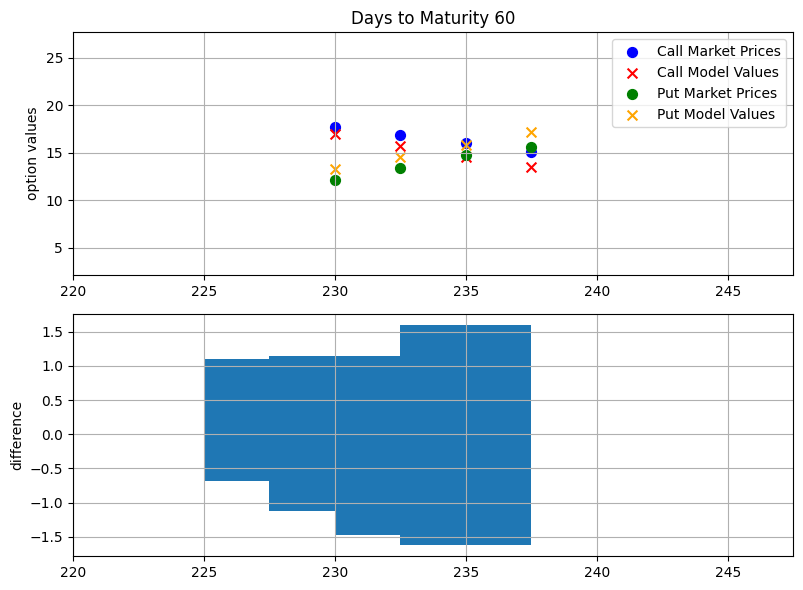

In [ ]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options_data_60.iterrows():
      if  option.Type =="C":
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
      else:
        model_value = B96_put_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

      values.append(model_value)

    return np.array(values)

def plot_full_calibration_results(p0):
    options_data_60["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Days to Maturity %s" % str(options_data_60["Days to maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.scatter(options_data_60.Strike[options_data_60.Type=="C"], options_data_60.Price[options_data_60.Type=="C"], label="Call Market Prices", color="blue", marker="o", s=50)
    plt.scatter(options_data_60.Strike[options_data_60.Type=="C"], options_data_60.Model[options_data_60.Type=="C"], label="Call Model Values", color="red", marker="x", s=50)
    plt.scatter(options_data_60.Strike[options_data_60.Type=="P"], options_data_60.Price[options_data_60.Type=="P"], label="Put Market Prices", color="green", marker="o", s=50)
    plt.scatter(options_data_60.Strike[options_data_60.Type=="P"], options_data_60.Model[options_data_60.Type=="P"], label="Put Model Values", color="orange", marker="x", s=50)
    plt.legend(loc=0)
    plt.axis(
        [
            min(options_data_60.Strike) - 10,
            max(options_data_60.Strike) + 10,
            min(options_data_60.Price) - 10,
            max(options_data_60.Price) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options_data_60.Model.values - options_data_60.Price.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options_data_60.Strike) - 10,
            max(options_data_60.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()
plot_full_calibration_results(full_params)
fp1 = full_params
fp1

## **2.b. FFT Approach - Carr and Madan (1999)**

As an alternative to Lewis (2001), we could also implement the FFT algorithm. Essentially, we can apply FFT to the integral in the call option price derived by Carr and Madan (1999):
$$
\
\begin{equation*}
    C_0 = \frac{e^{-\alpha \kappa}}{\pi} \int_{0}^{\infty} e^{-i\nu \kappa} \frac{e^{-rT} \varphi^{B96} (\nu - (\alpha + 1)i, T)}{\alpha^2 + \alpha - \nu^2 + i(2\alpha + 1)\nu} d\nu
\end{equation*}
$$
\
We basically have to adapt the characteristic function we are considering to be the Bates (1996).

Now by only changing the B96_call_value function() for discrete Fourier transform i.e. FFT implementation, we repeat the process of 2.a


In [ ]:
i = 0
min_MSE = 500
local_opt = False

options_data_60 = data[data["Days to maturity"] == 60]
options_data_60  = options_data_60[(np.abs(options_data_60["Strike"] - S0) / S0) < tol]
options_data_60["T"] = options_data_60["Days to maturity"] / 250.0  # Assuming 1 year has 250 trading days
options_data_60["r"] = 0.015  # Annual risk-free rate of 1.50%

# Error function for parameter calibration
def H93_error_function(p0):
    """Error function for parameter calibration via Lewis (2001) Fourier approach for Heston (1993)."""
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options_data_60.iterrows():
        if option["Type"] == "C":
            model_value = H93_call_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
            )
        else:
            model_value = H93_put_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
    )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

# Calibrates Heston (1993) stochastic volatility model to market quotes
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force (scan sensible regions for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),    # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),   # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),  # v0
        ),
        finish=None,
    )

    # Second run with local, convex minimization (dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

# Run the calibration
i = 0
min_MSE = 500


result = H93_calibration_full()
print("Calibration Result:")
print(result)


kappa_v, theta_v, sigma_v, rho, v0 = result


# Error function for parameter calibration
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 500
    se = []
    for row, option in options_data_60.iterrows():
      if option["Type"] == "C":
         model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
         )
      else:
            model_value = B96_put_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
                lamb,
                mu,
                delta,
      )

    se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE



def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """

    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========

    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue


def B96_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    call_value = B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    put_value = call_value + K * np.exp(-r * T) - S0

    return put_value



def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

params = B96_calibration_short()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] | 112.297 | 112.297
  25 | [ 2.5   0.02  0.05 -0.75  0.02] |  76.851 |  64.216
  50 | [ 2.5   0.02  0.25 -0.75  0.03] |  61.121 |  58.881
  75 | [ 2.5   0.03  0.15 -0.5   0.01] |  93.257 |  54.001
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |  64.455 |  49.630
 125 | [ 2.5   0.04  0.25 -0.5   0.03] |  51.189 |  49.520
 150 | [ 7.5   0.01  0.15 -0.25  0.01] | 112.749 |  49.520
 175 | [ 7.5   0.02  0.05 -0.25  0.02] |  76.721 |  49.520
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  66.134 |  49.520
 225 | [7.5  0.03 0.15 0.   0.01] |  75.003 |  49.520
 250 | [7.5  0.04 0.05 0.   0.02] |  52.618 |  44.757
 275 | [7.5  0.04 0.25 0.   0.03] |  45.291 |  44.731
 300 | [ 9.21694329e+00  6.78192087e-02  3.91683465e-02 -1.65139018e-03
  3.44282888e-02] |  22.102 |  22.102


<ipython-input-6-6b61c9e742bc>:27: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



 325 | [ 1.42800592e+01  1.39051809e-01  2.82623032e-03 -6.01985177e-03
  4.59770881e-02] |   1.607 |   1.593
 350 | [ 1.41016615e+01  1.36609558e-01  2.45828793e-03 -5.72674791e-03
  4.61550621e-02] |   1.594 |   1.593
 375 | [ 1.41707665e+01  1.36744127e-01  2.24190189e-03 -5.73125847e-03
  4.63906114e-02] |   1.593 |   1.593
 400 | [ 1.41547291e+01  1.36807891e-01  2.15798215e-03 -5.72031630e-03
  4.63506872e-02] |   1.593 |   1.593
 425 | [ 1.41445580e+01  1.36851417e-01  2.10231425e-03 -5.71433285e-03
  4.63261575e-02] |   1.593 |   1.593
 450 | [ 1.41289089e+01  1.36899059e-01  2.00286387e-03 -5.70086674e-03
  4.62938829e-02] |   1.593 |   1.593
 475 | [ 1.39149741e+01  1.37534037e-01  5.65172978e-04 -5.51085689e-03
  4.59376484e-02] |   1.593 |   1.593
 500 | [ 1.38493685e+01  1.37729510e-01  1.20296168e-04 -5.45253144e-03
  4.58334315e-02] |   1.593 |   1.593
 525 | [ 1.38345274e+01  1.37773994e-01  1.89924565e-05 -5.43921628e-03
  4.58093075e-02] |   1.593 |   1.593


<ipython-input-6-6b61c9e742bc>:27: IntegrationWarning:

The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



 550 | [ 1.38327249e+01  1.37778960e-01  5.82458106e-06 -5.43750410e-03
  4.58073268e-02] |   1.593 |   1.593
 575 | [ 1.38327674e+01  1.37778797e-01  6.01122667e-06 -5.43752998e-03
  4.58074791e-02] |   1.593 |   1.593
 600 | [ 1.38327392e+01  1.37778875e-01  5.80834210e-06 -5.43750333e-03
  4.58074447e-02] |   1.593 |   1.593
 625 | [ 1.38327356e+01  1.37778886e-01  5.78445092e-06 -5.43750016e-03
  4.58074379e-02] |   1.593 |   1.593
 650 | [ 1.38327359e+01  1.37778885e-01  5.78698540e-06 -5.43750049e-03
  4.58074378e-02] |   1.593 |   1.593
 675 | [ 1.38327358e+01  1.37778886e-01  5.78654158e-06 -5.43750043e-03
  4.58074377e-02] |   1.593 |   1.593
 700 | [ 1.38327358e+01  1.37778886e-01  5.78639505e-06 -5.43750041e-03
  4.58074377e-02] |   1.593 |   1.593
 725 | [ 1.38327358e+01  1.37778886e-01  5.78647031e-06 -5.43750042e-03
  4.58074377e-02] |   1.593 |   1.593
 750 | [ 1.38327358e+01  1.37778886e-01  5.78647865e-06 -5.43750042e-03
  4.58074377e-02] |   1.593 |   1.593
 775 | [ 1

In [ ]:
def B96_jump_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    lamb, mu, delta = p0
    kappa_v, theta_v, sigma_v, rho, v0 = result
    values = []
    for row, option in options_data_60.iterrows():
        r = 0.015
        if option.Type == "C":
          model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
          )
        else:
          model_value = B96_put_value(
            S0,
            option["Strike"],
            option["T"],
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
          )
        values.append(model_value)
    return np.array(values)
B96_result = B96_jump_calculate_model_values(params)
print(B96_result)

[16.96882755 15.73922076 14.57496037 13.47500708 13.24231616 14.50372555
 15.83048134 17.22154424]


In [ ]:
i = 0
min_MSE = 500
kappa_v, theta_v, sigma_v, rho, v0 = result
lamb, mu, delta = params
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 500

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500

    se = []
    for row, option in options_data_60.iterrows():
      if option.Type == "C":
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
         )
      else:
          model_value = B96_put_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
         )
      se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt
full_params = B96_calibration_full()

   0 | [ 1.38327358e+01  1.37778886e-01  5.78647885e-06 -5.43750042e-03
  4.58074377e-02  0.00000000e+00 -5.00000000e-01  0.00000000e+00] |   1.593 |   1.593
  25 | [ 1.36627921e+01  1.37973847e-01  5.85072743e-06 -5.49787422e-03
  4.55441012e-02  5.55161271e-05 -5.05551613e-01  5.55161271e-05] |   1.594 |   1.593
  50 | [ 1.38277621e+01  1.37763316e-01  5.95637951e-06 -5.46121699e-03
  4.58470758e-02  1.39945229e-05 -5.02180833e-01  2.18083342e-05] |   1.593 |   1.593
  75 | [ 1.38306287e+01  1.37783236e-01  6.02596929e-06 -5.45864110e-03
  4.58083233e-02  4.87108268e-06 -4.98037720e-01  1.94397041e-05] |   1.593 |   1.593
 100 | [ 1.38320397e+01  1.37779435e-01  6.00982333e-06 -5.45433436e-03
  4.58100458e-02  4.38379369e-06 -5.02229953e-01  6.30107743e-06] |   1.593 |   1.593
Optimization terminated successfully.
         Current function value: 1.593417
         Iterations: 43
         Function evaluations: 114


array([ 1.38313564e+01,  1.37780910e-01,  6.01664087e-06, -5.44987527e-03,
        4.58099094e-02,  5.75947639e-06, -5.01137917e-01,  1.13791730e-05])

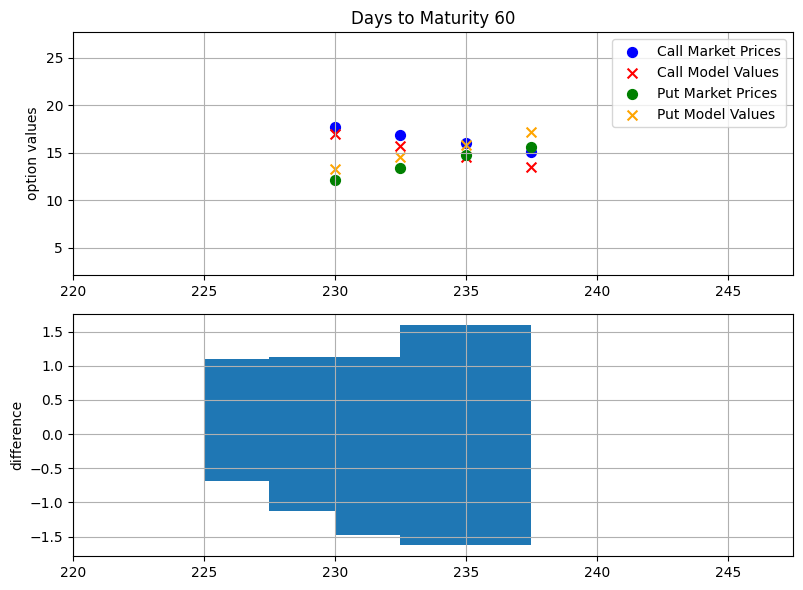

In [ ]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options_data_60.iterrows():
      if  option.Type =="C":
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
      else:
        model_value = B96_put_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

      values.append(model_value)

    return np.array(values)

def plot_full_calibration_results(p0):
    options_data_60["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Days to Maturity %s" % str(options_data_60["Days to maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.scatter(options_data_60.Strike[options_data_60.Type=="C"], options_data_60.Price[options_data_60.Type=="C"], label="Call Market Prices", color="blue", marker="o", s=50)
    plt.scatter(options_data_60.Strike[options_data_60.Type=="C"], options_data_60.Model[options_data_60.Type=="C"], label="Call Model Values", color="red", marker="x", s=50)
    plt.scatter(options_data_60.Strike[options_data_60.Type=="P"], options_data_60.Price[options_data_60.Type=="P"], label="Put Market Prices", color="green", marker="o", s=50)
    plt.scatter(options_data_60.Strike[options_data_60.Type=="P"], options_data_60.Model[options_data_60.Type=="P"], label="Put Model Values", color="orange", marker="x", s=50)
    plt.legend(loc=0)
    plt.axis(
        [
            min(options_data_60.Strike) - 10,
            max(options_data_60.Strike) + 10,
            min(options_data_60.Price) - 10,
            max(options_data_60.Price) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options_data_60.Model.values - options_data_60.Price.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options_data_60.Strike) - 10,
            max(options_data_60.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()
plot_full_calibration_results(full_params)
fp2 = full_params
fp2

# Step 3

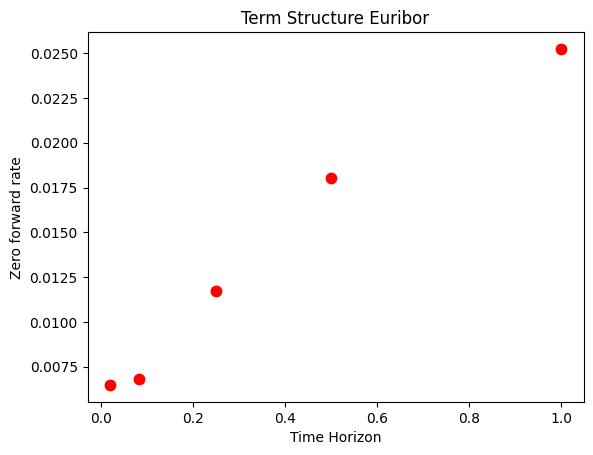

In [ ]:
mat_list = np.array((7, 30, 90, 180, 360)) / 360
rate_list = (
    np.array((0.00648, 0.00679, 0.01173, 0.01809, 0.02556))
)
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)
plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

In [ ]:
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 52
)  # Create 52 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

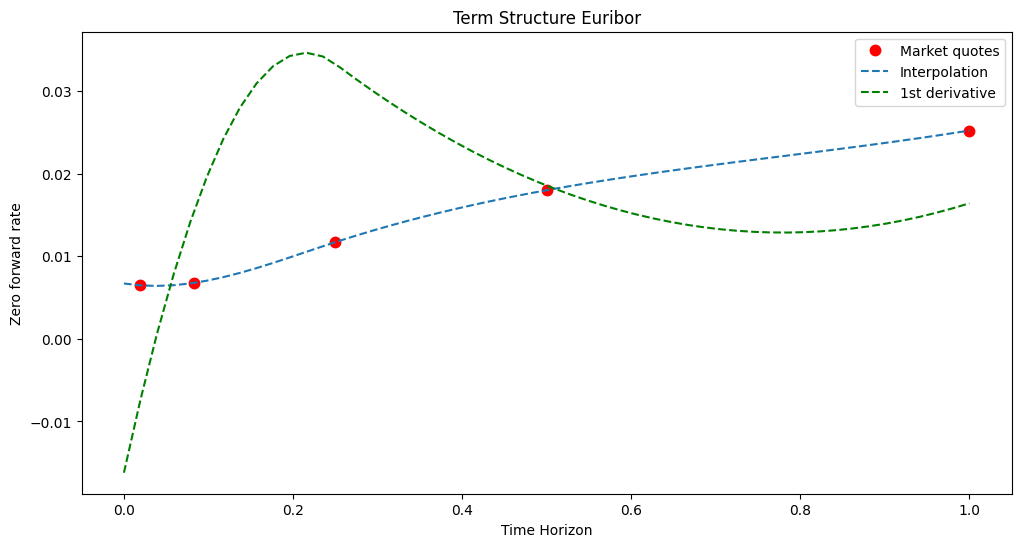

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [ ]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [0.009, 0.001, 0.001],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

In [ ]:
params_CIR = CIR_calibration()
kappa_CIR, theta_CIR, sigma_CIR = params_CIR
print(f"\nCalibration parameters for CIR model: \n========================\nkappa = {np.round(kappa_CIR,4)}, \ntheta= {np.round(theta_CIR,4)}, \nsigma= {np.round(sigma_CIR,4)}")

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 160
         Function evaluations: 298

Calibration parameters for CIR model: 
kappa = 0.9965, 
theta= 0.1076, 
sigma= 0.0498


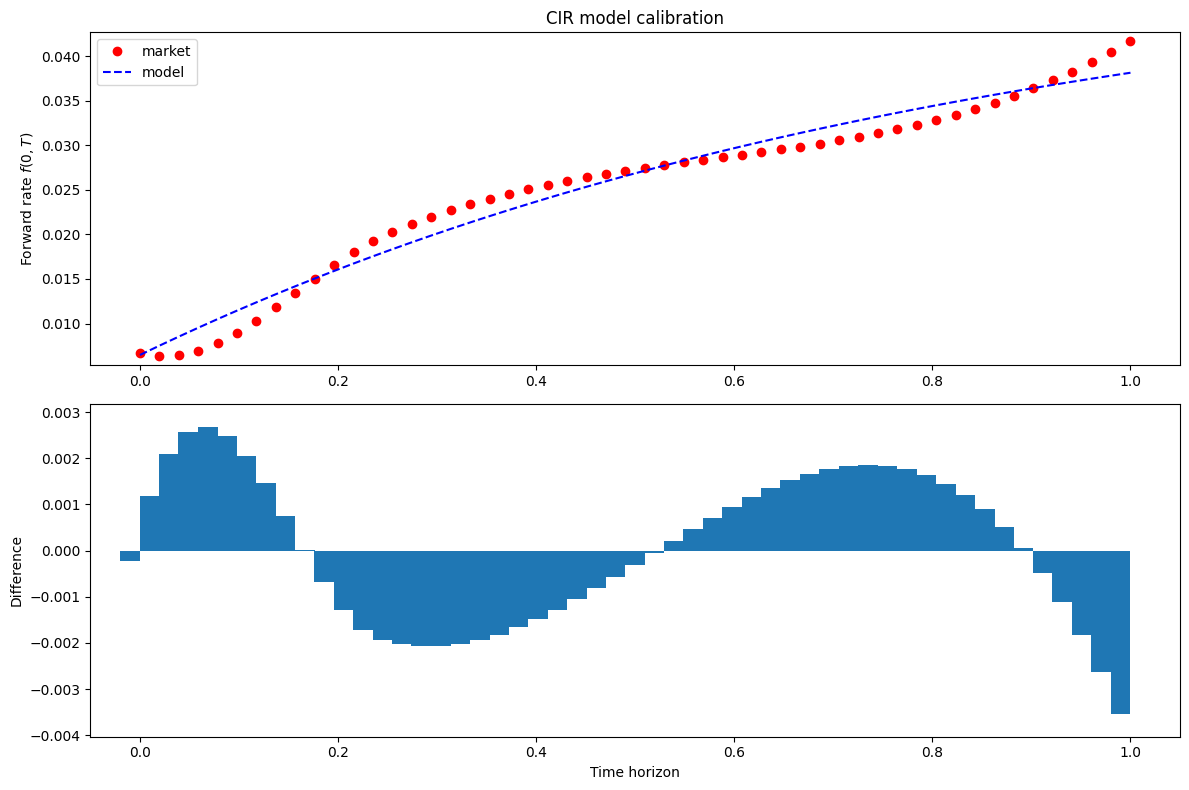

In [ ]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [np.min(mat_list_n) - 0.05, np.max(mat_list_n) + 0.05, np.min(f) - 0.001, np.max(f) + 0.001]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            np.min(mat_list_n) - 0.05,
            np.max(mat_list_n) + 0.05,
            np.min(forward_rates - f) - 0.0005,
            np.max(forward_rates - f) + 0.0005,
        ]
    )
    plt.tight_layout()
plot_calibrated_frc(params_CIR)

In [ ]:
def vasicek(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma * np.sqrt(dt) * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

def cir(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

M = 100000  # Number of paths for MC
N = 100  # Number of steps
T = 1.0  # Maturity
r0 = 0.02556 #Euribor 12-month rates
kappa_CIR, theta_CIR, sigma_CIR = params_CIR #calibrated parameters
t = np.linspace(0, T, N)

np.random.seed(123)
rates_cir = cir(r0, kappa_CIR, theta_CIR, sigma_CIR, T, N, M)

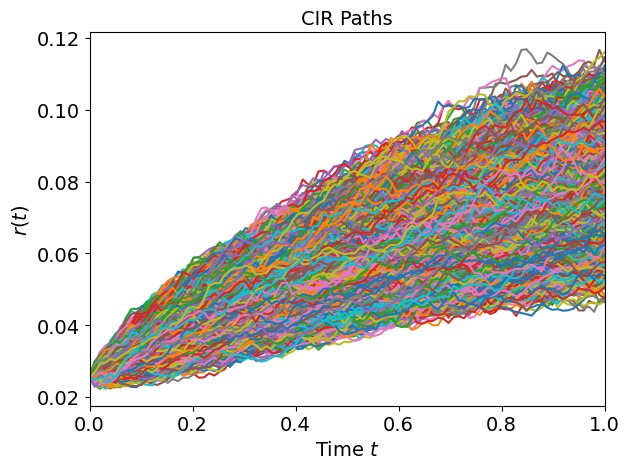

In [ ]:
for j in range(M):
    plt.plot(t, rates_cir[:, j])

plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("$r(t)$", fontsize=14)
plt.title("CIR Paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
max = np.max(rates_cir[-1])
min = np.min(rates_cir[-1])
expected_value = np.average(rates_cir[-1])
print("Max:{:.6f}".format(max))
print("Min:{:.6f}".format(min))
print("Expected value:{:.6f}".format(expected_value))

Max:0.116022
Min:0.046430
Expected value:0.077187


From the simulated results, Euribor 12-month rates after 1 year would be between 0.1761% and 2.5835%. The expected value would be 1.0406%.

If the expected number is lower than the current rate, which in other words mean interest rate is expected to decrease, the value of the short-term OTC instrument would increase. This is because investors cannot earn a higher yield by investing in new instruments with higher interest rates.